## Analysis of the parsed points and generated pointclouds
### Author: Vilem Gottwald

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path
from pyntcloud import PyntCloud
from modules import listdir_paths
from matplotlib import pyplot as plt
import seaborn as sns

PROJECT_ROOT = Path(globals()['_dh'][0]).resolve().parent
sys.path.append(str(PROJECT_ROOT))

# Path to the directory containing all data
DATA_PATH = PROJECT_ROOT / "data"
UNFILTERED_POINTS_PKL_PATH = str(DATA_PATH / "parsing" / 'pandas_saved' / 'unfiltered_radar_points.pkl')
PLOTS_DIR = str(DATA_PATH / "plots")

# Load the unfiltered points

In [2]:
df_points = pd.read_pickle(UNFILTERED_POINTS_PKL_PATH)
df_points.head()

,range,azimuth,elevation,doppler,targetID,snr,noise,frame,x,y,z
0,29.577906,0.418861,0.048068,3.616898,254.0,157.0,541.0,80.0,12.016024,26.990476,4.592135
1,59.259064,0.419547,0.073392,5.787037,254.0,171.0,519.0,80.0,24.073995,54.132578,4.663052
2,59.625496,0.419332,0.066509,5.787037,254.0,124.0,519.0,80.0,24.222857,54.455752,4.248838
3,57.060459,0.188682,0.026312,33.998840,254.0,120.0,543.0,80.0,10.698836,55.878352,1.652115
4,57.060459,0.188621,0.007075,34.360531,254.0,123.0,542.0,80.0,10.698836,55.782184,0.570678


In [3]:
len(df_points)

1155104

### Functions for experimenting with filtering, and ploting histograms of point distributions

In [4]:
def remove_and_count_removed(df, mask):
    removed = df[mask]
    df = df[~mask]
    print(f'Removed {len(removed)} rows')
    return df


def save_histplot(df, column, title, xlabel=None, ylabel=None, log_scale=False):
    plt.figure(figsize=(7, 5))
    # logaritmic scale
    sns.histplot(df[column], bins=100, log_scale=log_scale)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig(os.path.join(PLOTS_DIR, f'{title.replace(" ", "_")}.pdf'), format='pdf')
    plt.show()
    plt.close()
    

def save_2D_histplot(df, column1, column2, pre_filtering=True):
    plt.figure(figsize=(7, 5))
    title = f'Distribution of points in the {column1} and {column2} plane {"before" if pre_filtering else "after"} filtering'
    sns.histplot(df, x=column1, y=column2, cbar=True)
    plt.xlabel(f'{column1} coordinate [m]')
    plt.ylabel(f'{column2} coordinate [m]')
    plt.title(title)
    plt.savefig(os.path.join(PLOTS_DIR, f'{title.replace(" ", "_")}.pdf'), format='pdf')
    plt.show()
    plt.close()

## Filtering

### Remove corrupted points

In [5]:
df_points = remove_and_count_removed(df_points, (df_points['targetID'] > 255) | (df_points['targetID'] < 0))


Removed 192 rows


### X axis corrupted filtering

In [6]:
df_points =  remove_and_count_removed(df_points, (df_points['x'].abs() > 1000))


Removed 1 rows


## Plot distributions

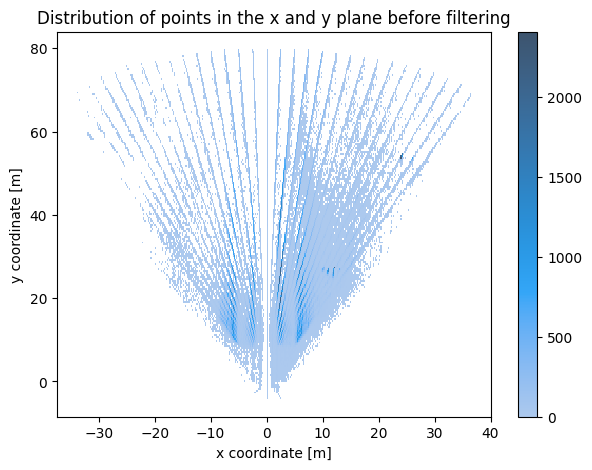

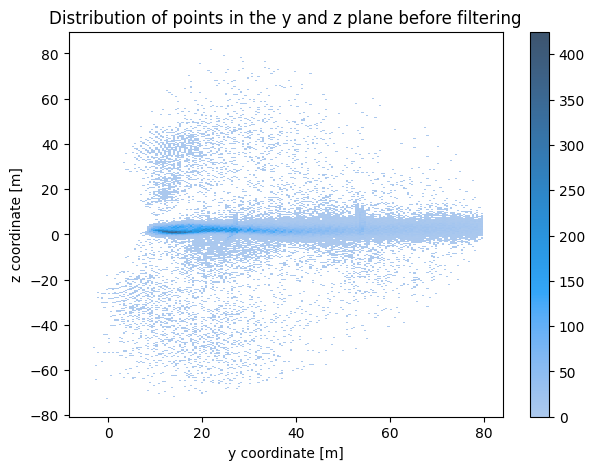

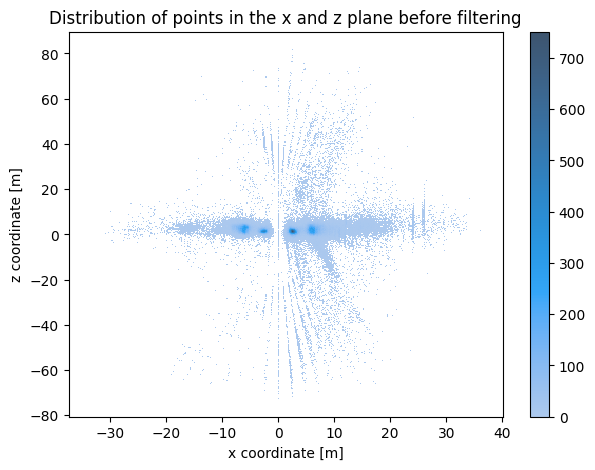

In [7]:
save_2D_histplot(df_points, 'x', 'y',)
save_2D_histplot(df_points, 'y', 'z',)
save_2D_histplot(df_points, 'x', 'z',)

### X axis filtering

In [8]:
# save_histplot(df_points, 'x', 'Histogram of points x coordinate before filtering', 'x coordinate [m]', 'Number of points')
df_points = remove_and_count_removed(df_points, (df_points['x'] >= 10) | (df_points['x'] <= -10) | (df_points['x'] == 0))
# save_histplot(df_points, 'x', 'Histogram of points x coordinate after filtering', 'x coordinate [m]', 'Number of points')

Removed 124677 rows


### Y axis filtering

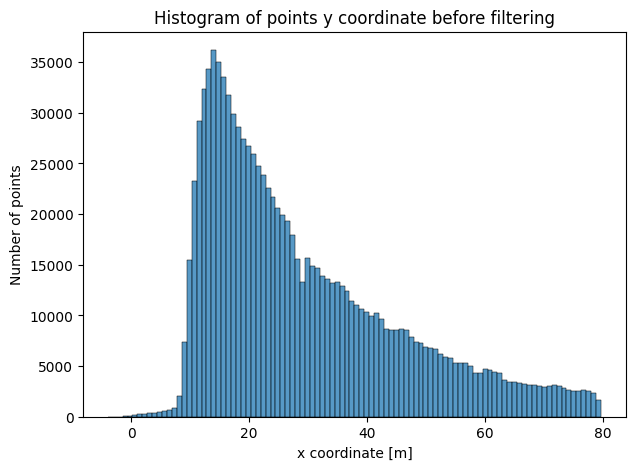

Removed 160 rows


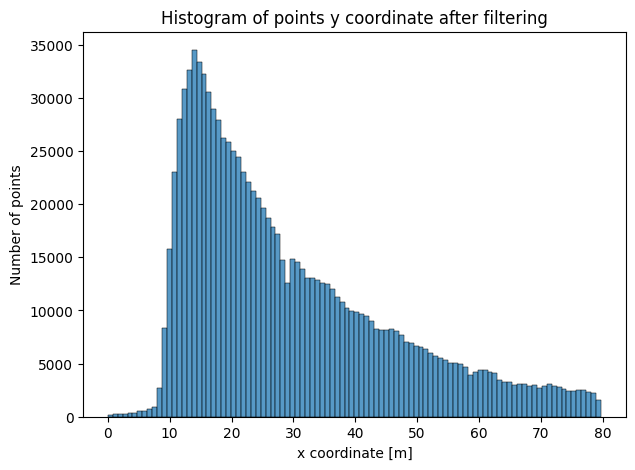

In [9]:
save_histplot(df_points, 'y', 'Histogram of points y coordinate before filtering', 'x coordinate [m]', 'Number of points')
df_points = remove_and_count_removed(df_points, (df_points['y'] <= 0) | (df_points['y'] >= 85))
save_histplot(df_points, 'y', 'Histogram of points y coordinate after filtering', 'x coordinate [m]', 'Number of points')

### Z axis filtering

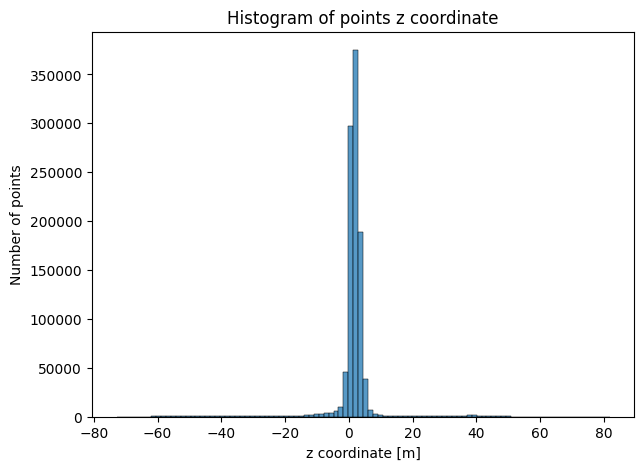

Removed 141108 rows


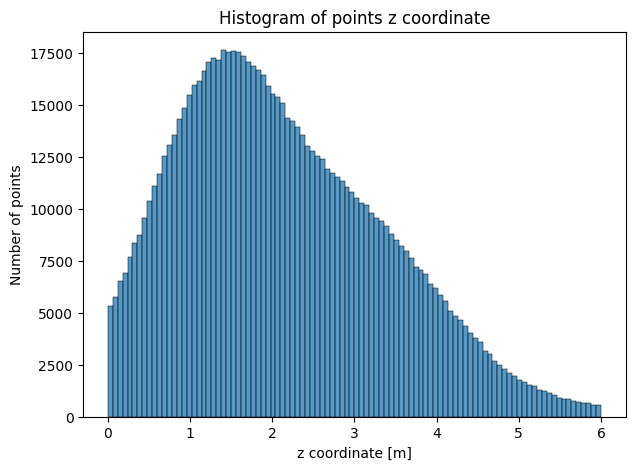

In [10]:
save_histplot(df_points, 'z', 'Histogram of points z coordinate', 'z coordinate [m]', 'Number of points', log_scale=False)
df_points = remove_and_count_removed(df_points, (df_points['z'] <= 0) | (df_points['z'] >= 6))
save_histplot(df_points, 'z', 'Histogram of points z coordinate', 'z coordinate [m]', 'Number of points', log_scale=False)


### Velocity direction based filtering

In [11]:
mask = ((df_points['x'] <= 0) & (df_points['doppler'] > 0)) | ((df_points['x'] > 0) & (df_points['doppler'] <= 0))
df_points = remove_and_count_removed(df_points, mask)

Removed 9847 rows


In [12]:
len(df_points)

879119

## Distributions after filtering

In [ ]:
save_2D_histplot(df_points, 'x', 'y', pre_filtering=False)
save_2D_histplot(df_points, 'y', 'z', pre_filtering=False)
save_2D_histplot(df_points, 'x', 'z', pre_filtering=False)

### Ploting histograms into one figure

In [ ]:
def histplot_trio(df, columns):
    %matplotlib inline

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

    if type(columns[0]) is str:
        sns.histplot(df, x=columns[0], ax=ax1)
        sns.histplot(df, x=columns[1], ax=ax2)
        sns.histplot(df, x=columns[2], ax=ax3)
    else:
        sns.histplot(df, x=columns[0][0], y=columns[0][1], ax=ax1)
        sns.histplot(df, x=columns[1][0], y=columns[1][1], ax=ax2)
        sns.histplot(df, x=columns[2][0], y=columns[2][1], ax=ax3)

    plt.show()

In [ ]:
histplot_trio(df_points, ['x', 'y', 'z'])

In [ ]:
histplot_trio(df_points, [('x', 'y'), ('y', 'z'), ('x', 'z')])

In [ ]:
histplot_trio(df_points, [('y', 'doppler'), ('snr', 'noise'), ('noise', 'z')])

In [ ]:
histplot_trio(df_points, ['snr', 'noise', 'doppler'])

## Count mean number of points per frame after the grouping in PLY files

In [ ]:
POINTCLOUDS_DIR = str(DATA_PATH / "labeling" / "pointclouds")


# get point cloud files fullpaths
fullpaths = listdir_paths(POINTCLOUDS_DIR)

points = []
for fullpath in fullpaths:
    cloud = PyntCloud.from_file(fullpath)
    points.append(cloud.points.shape[0])

print(f"Average number of points: {np.mean(points)}")
print(f"Standard deviation: {np.std(points)}")